In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor

In [2]:
# Configure problem number
PROBLEM_NUM = 36

X_path = f"./data_31_40/problem_{PROBLEM_NUM}/dataset_{PROBLEM_NUM}.csv"
y_path = f"./data_31_40/problem_{PROBLEM_NUM}/target_{PROBLEM_NUM}.csv"
Xeval_path = f"./data_31_40/problem_{PROBLEM_NUM}/EVAL_{PROBLEM_NUM}.csv"

X = pd.read_csv(X_path)
y = pd.read_csv(y_path)
X_eval = pd.read_csv(Xeval_path)

y1 = y["target01"]

print(f"Problem {PROBLEM_NUM}")
print(f"X: {X.shape}, y1: {y1.shape}, X_eval: {X_eval.shape}")

# Create train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y1, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nTrain/Val Split:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

Problem 36
X: (10000, 273), y1: (10000,), X_eval: (10000, 273)

Train/Val Split:
X_train: (8000, 273), y_train: (8000,)
X_val: (2000, 273), y_val: (2000,)


In [3]:
# Train basic CatBoost model with default parameters
print("Training CatBoost with default parameters...")
print("="*80)

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=100
)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50,
    plot=False
)

print("\n" + "="*80)
print("Training Complete!")
print("="*80)

Training CatBoost with default parameters...
0:	learn: 0.2266294	test: 0.2275526	best: 0.2275526 (0)	total: 187ms	remaining: 3m 6s
100:	learn: 0.1389720	test: 0.1591532	best: 0.1591532 (100)	total: 6.1s	remaining: 54.3s
200:	learn: 0.0797858	test: 0.1142610	best: 0.1142331 (195)	total: 12.3s	remaining: 48.7s
300:	learn: 0.0622737	test: 0.1067448	best: 0.1067422 (299)	total: 18.1s	remaining: 41.9s
400:	learn: 0.0539884	test: 0.1062320	best: 0.1062320 (400)	total: 19.9s	remaining: 29.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1060504838
bestIteration = 445

Shrink model to first 446 iterations.

Training Complete!


In [4]:
# Evaluate model
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("\nModel Performance:")
print("="*80)
print(f"{'Metric':<20} {'Train':<15} {'Validation':<15} {'Gap':<15}")
print("="*80)
print(f"{'RMSE':<20} {train_rmse:<15.4f} {val_rmse:<15.4f} {val_rmse - train_rmse:<15.4f}")
print(f"{'R²':<20} {train_r2:<15.4f} {val_r2:<15.4f} {train_r2 - val_r2:<15.4f}")
print("="*80)

if val_rmse - train_rmse > 0.05:
    print("\n⚠️ Warning: Model shows signs of overfitting (RMSE gap > 0.05)")
else:
    print("\n✓ Good generalization (RMSE gap < 0.05)")


Model Performance:
Metric               Train           Validation      Gap            
RMSE                 0.0506          0.1061          0.0554         
R²                   0.9509          0.7856          0.1652         

⚠️ Warning: Model shows signs of overfitting (RMSE gap > 0.05)


In [5]:
# Get feature importances
feature_importance = model.get_feature_importance()

# Create dataframe with feature names and importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n" + "="*80)
print("TOP 30 MOST IMPORTANT FEATURES")
print("="*80)
print(importance_df.head(30).to_string(index=False))

print("\n" + "="*80)
print("BOTTOM 20 LEAST IMPORTANT FEATURES")
print("="*80)
print(importance_df.tail(20).to_string(index=False))

# Statistics
print("\n" + "="*80)
print("FEATURE IMPORTANCE STATISTICS")
print("="*80)
print(f"Total features: {len(importance_df)}")
print(f"Mean importance: {importance_df['importance'].mean():.4f}")
print(f"Median importance: {importance_df['importance'].median():.4f}")
print(f"Max importance: {importance_df['importance'].max():.4f}")
print(f"Min importance: {importance_df['importance'].min():.4f}")

# Calculate cumulative importance
importance_df['cumulative'] = importance_df['importance'].cumsum() / importance_df['importance'].sum() * 100
n_features_80 = (importance_df['cumulative'] <= 80).sum() + 1
n_features_90 = (importance_df['cumulative'] <= 90).sum() + 1
n_features_95 = (importance_df['cumulative'] <= 95).sum() + 1

print(f"\nFeatures for 80% importance: {n_features_80} ({n_features_80/len(importance_df)*100:.1f}%)")
print(f"Features for 90% importance: {n_features_90} ({n_features_90/len(importance_df)*100:.1f}%)")
print(f"Features for 95% importance: {n_features_95} ({n_features_95/len(importance_df)*100:.1f}%)")


TOP 30 MOST IMPORTANT FEATURES
 feature  importance
 feat_64   29.159078
feat_184   16.354353
feat_155   12.652556
feat_221    3.625330
feat_143    3.546301
feat_253    3.528754
feat_232    3.488072
feat_220    2.278584
feat_266    1.130102
feat_160    1.037715
feat_138    0.497064
feat_203    0.471880
 feat_47    0.366858
 feat_18    0.264129
  feat_5    0.231220
feat_207    0.227634
feat_112    0.209533
 feat_83    0.207582
 feat_74    0.203507
feat_100    0.202969
feat_197    0.196924
feat_233    0.178567
feat_199    0.173857
feat_153    0.167897
feat_167    0.165965
feat_121    0.164034
feat_194    0.162335
feat_242    0.161949
 feat_46    0.161914
feat_261    0.161451

BOTTOM 20 LEAST IMPORTANT FEATURES
 feature  importance
 feat_41    0.026965
feat_120    0.026712
 feat_81    0.026552
 feat_55    0.026193
feat_168    0.025815
feat_119    0.023827
feat_218    0.022580
feat_130    0.020556
 feat_52    0.018666
 feat_88    0.017226
feat_159    0.016233
feat_144    0.015328
feat_238

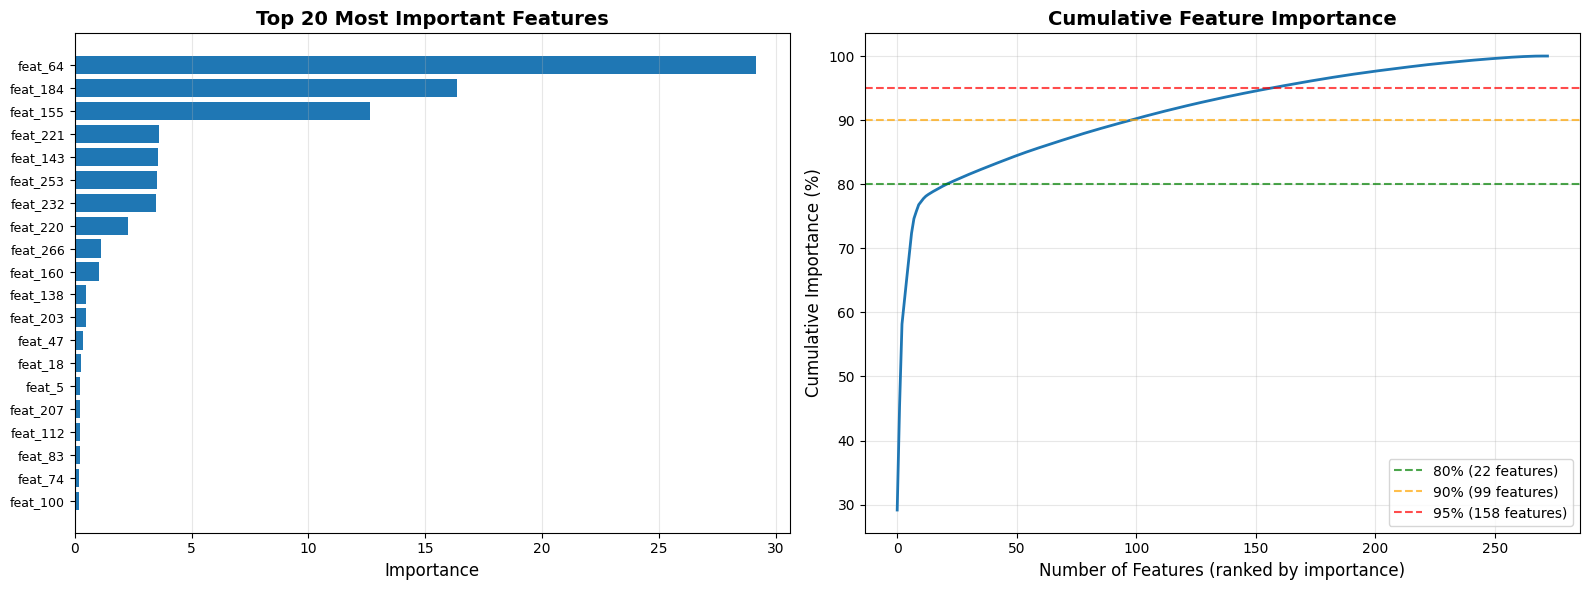


✓ Feature importance analysis complete!


In [6]:
# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 features bar plot
top_20 = importance_df.head(20)
axes[0].barh(range(len(top_20)), top_20['importance'])
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['feature'], fontsize=9)
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Cumulative importance plot
axes[1].plot(range(len(importance_df)), importance_df['cumulative'].values, linewidth=2)
axes[1].axhline(y=80, color='green', linestyle='--', linewidth=1.5, label=f'80% ({n_features_80} features)', alpha=0.7)
axes[1].axhline(y=90, color='orange', linestyle='--', linewidth=1.5, label=f'90% ({n_features_90} features)', alpha=0.7)
axes[1].axhline(y=95, color='red', linestyle='--', linewidth=1.5, label=f'95% ({n_features_95} features)', alpha=0.7)
axes[1].set_xlabel('Number of Features (ranked by importance)', fontsize=12)
axes[1].set_ylabel('Cumulative Importance (%)', fontsize=12)
axes[1].set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Feature importance analysis complete!")

In [7]:
# Generate predictions on evaluation set
print("\n" + "="*80)
print("Generating predictions on evaluation set...")
print("="*80)

eval_pred = model.predict(X_eval)

# Save predictions
output_filename = f"EVAL_target01_{PROBLEM_NUM}_catboost_basic.csv"
submission = pd.DataFrame({"target01": eval_pred})
submission.to_csv(output_filename, index=False)

print(f"\n✓ Saved: {output_filename}")
print(f"Predictions shape: {eval_pred.shape}")
print(f"Predictions range: [{eval_pred.min():.4f}, {eval_pred.max():.4f}]")
print(f"\nExpected Test RMSE: ~{val_rmse:.4f} (based on validation)")


Generating predictions on evaluation set...

✓ Saved: EVAL_target01_36_catboost_basic.csv
Predictions shape: (10000,)
Predictions range: [-0.5348, 0.2560]

Expected Test RMSE: ~0.1061 (based on validation)


In [9]:
# Incremental feature analysis - add features one by one
print("=" * 80)
print("INCREMENTAL FEATURE ANALYSIS")
print("=" * 80)
print("Training models with progressively more features (by importance)...\n")

# Define feature counts to test
feature_counts = [1,2,4, 5,6,7,8,9, 10,11,12,13,14,15,16,17,18,19, 20,21, 30, 50, 75, 100, 150, 200, len(importance_df)]

results = []

for n_features in feature_counts:
    if n_features > len(importance_df):
        continue
    
    # Get top N features
    top_features = importance_df.head(n_features)['feature'].tolist()
    
    # Subset data
    X_train_subset = X_train[top_features]
    X_val_subset = X_val[top_features]
    
    # Train model
    model_subset = CatBoostRegressor(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        random_state=42,
        verbose=0
    )
    
    model_subset.fit(
        X_train_subset, y_train,
        eval_set=(X_val_subset, y_val),
        early_stopping_rounds=50,
        plot=False
    )
    
    # Evaluate
    y_train_pred = model_subset.predict(X_train_subset)
    y_val_pred = model_subset.predict(X_val_subset)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    results.append({
        'n_features': n_features,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'rmse_gap': val_rmse - train_rmse,
        'r2_gap': train_r2 - val_r2
    })
    
    print(f"Features: {n_features:>3} | Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f} | Val R²: {val_r2:.4f} | Gap: {val_rmse - train_rmse:.4f}")

# Convert to dataframe
results_df = pd.DataFrame(results)

print("\n" + "=" * 80)
print("INCREMENTAL FEATURE RESULTS")
print("=" * 80)
print(results_df.to_string(index=False))
print("\n✓ Incremental analysis complete!")

INCREMENTAL FEATURE ANALYSIS
Training models with progressively more features (by importance)...

Features:   1 | Train RMSE: 0.2282 | Val RMSE: 0.2290 | Val R²: 0.0004 | Gap: 0.0008
Features:   2 | Train RMSE: 0.2273 | Val RMSE: 0.2288 | Val R²: 0.0018 | Gap: 0.0016
Features:   4 | Train RMSE: 0.1084 | Val RMSE: 0.1177 | Val R²: 0.7357 | Gap: 0.0093
Features:   5 | Train RMSE: 0.0997 | Val RMSE: 0.1069 | Val R²: 0.7820 | Gap: 0.0072
Features:   6 | Train RMSE: 0.0952 | Val RMSE: 0.1075 | Val R²: 0.7795 | Gap: 0.0123
Features:   7 | Train RMSE: 0.0664 | Val RMSE: 0.0787 | Val R²: 0.8819 | Gap: 0.0123
Features:   8 | Train RMSE: 0.0552 | Val RMSE: 0.0711 | Val R²: 0.9037 | Gap: 0.0158
Features:   9 | Train RMSE: 0.0597 | Val RMSE: 0.0758 | Val R²: 0.8905 | Gap: 0.0161
Features:  10 | Train RMSE: 0.0546 | Val RMSE: 0.0750 | Val R²: 0.8928 | Gap: 0.0204
Features:  11 | Train RMSE: 0.0495 | Val RMSE: 0.0742 | Val R²: 0.8950 | Gap: 0.0247
Features:  12 | Train RMSE: 0.0429 | Val RMSE: 0.066

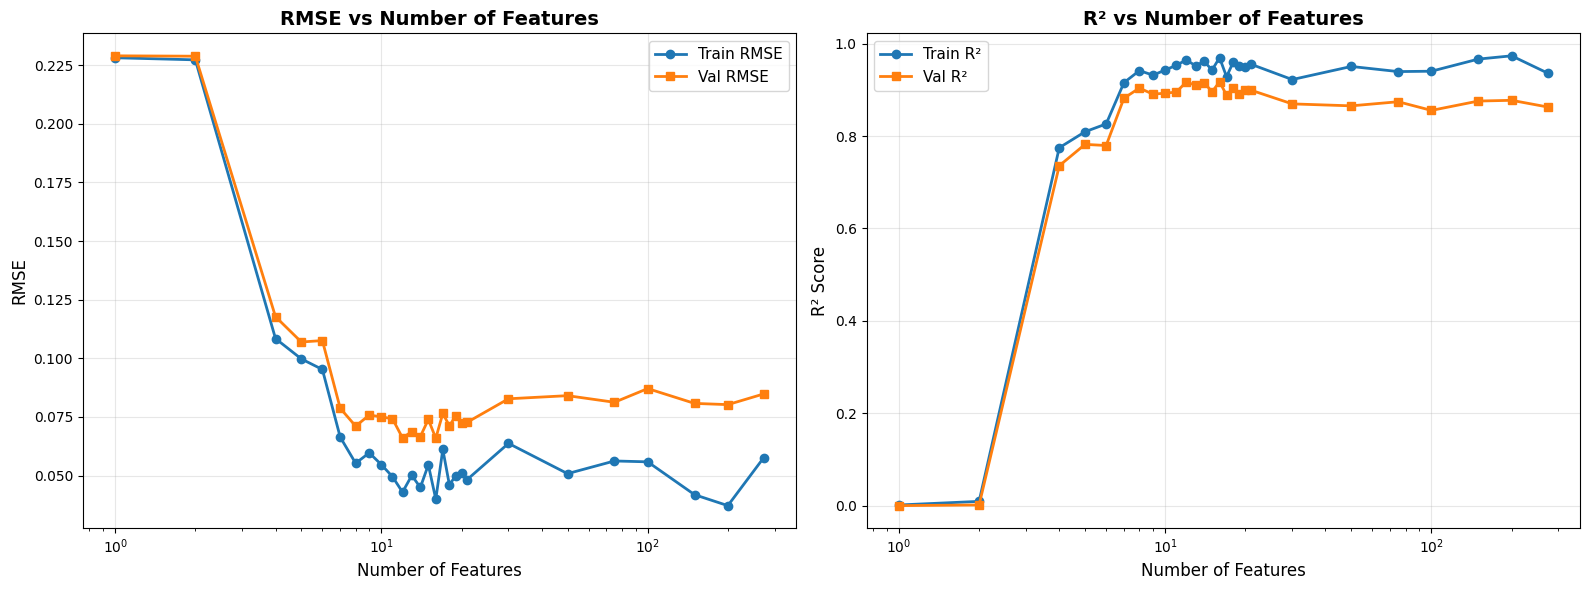


OPTIMAL FEATURE COUNT
Best validation R² achieved with 16 features
Val R²: 0.9172
Val RMSE: 0.0659
RMSE Gap: 0.0260

📊 Performance Improvement:
   1 feature  → Val R²: 0.0004, Val RMSE: 0.2290
   All features → Val R²: 0.8629, Val RMSE: 0.0848
   Improvement: ΔR² = 0.8625, ΔRMSE = 0.1442


In [10]:
# Visualize incremental feature performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE plot
axes[0].plot(results_df['n_features'], results_df['train_rmse'], marker='o', linewidth=2, label='Train RMSE')
axes[0].plot(results_df['n_features'], results_df['val_rmse'], marker='s', linewidth=2, label='Val RMSE')
axes[0].set_xlabel('Number of Features', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('RMSE vs Number of Features', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)
axes[0].set_xscale('log')

# R² plot
axes[1].plot(results_df['n_features'], results_df['train_r2'], marker='o', linewidth=2, label='Train R²')
axes[1].plot(results_df['n_features'], results_df['val_r2'], marker='s', linewidth=2, label='Val R²')
axes[1].set_xlabel('Number of Features', fontsize=12)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('R² vs Number of Features', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

# Find optimal number of features (best val R²)
best_idx = results_df['val_r2'].idxmax()
best_result = results_df.iloc[best_idx]

print("\n" + "=" * 80)
print("OPTIMAL FEATURE COUNT")
print("=" * 80)
print(f"Best validation R² achieved with {int(best_result['n_features'])} features")
print(f"Val R²: {best_result['val_r2']:.4f}")
print(f"Val RMSE: {best_result['val_rmse']:.4f}")
print(f"RMSE Gap: {best_result['rmse_gap']:.4f}")

# Performance improvement summary
first_result = results_df.iloc[0]
last_result = results_df.iloc[-1]
print(f"\n📊 Performance Improvement:")
print(f"   1 feature  → Val R²: {first_result['val_r2']:.4f}, Val RMSE: {first_result['val_rmse']:.4f}")
print(f"   All features → Val R²: {last_result['val_r2']:.4f}, Val RMSE: {last_result['val_rmse']:.4f}")
print(f"   Improvement: ΔR² = {last_result['val_r2'] - first_result['val_r2']:.4f}, ΔRMSE = {first_result['val_rmse'] - last_result['val_rmse']:.4f}")

In [11]:
importance_df

,feature,importance,cumulative
64,feat_64,29.159078,29.159078
184,feat_184,16.354353,45.513431
155,feat_155,12.652556,58.165987
221,feat_221,3.625330,61.791317
143,feat_143,3.546301,65.337618
...,...,...,...
210,feat_210,0.008595,99.996314
99,feat_99,0.003686,100.000000
131,feat_131,0.000000,100.000000
104,feat_104,0.000000,100.000000


## Incremental Feature Analysis

Test model performance by progressively adding features from most to least important.

In [ ]:
# Generate predictions with optimized model
print("\n" + "=" * 80)
print("Generating predictions with optimized model...")
print("=" * 80)

eval_pred_opt = model_optimized.predict(X_eval_top8)

# Save predictions
output_filename_opt = f"EVAL_target01_{PROBLEM_NUM}_catboost_optimized_8feat.csv"
submission_opt = pd.DataFrame({"target01": eval_pred_opt})
submission_opt.to_csv(output_filename_opt, index=False)

print(f"\n✓ Saved: {output_filename_opt}")
print(f"Predictions shape: {eval_pred_opt.shape}")
print(f"Predictions range: [{eval_pred_opt.min():.4f}, {eval_pred_opt.max():.4f}]")
print(f"\nExpected Test RMSE: ~{val_rmse_opt:.4f} (based on validation)")
print(f"Using only 8 features: {', '.join(top_8_features)}")

## Optimized Model with Top 8 Features

Using the best hyperparameters from Optuna optimization with only the 8 most important features.

In [14]:
# Train model with top 8 features and optimized parameters
print("=" * 80)
print("TRAINING WITH TOP 8 FEATURES + OPTIMIZED PARAMETERS")
print("=" * 80)

# Get top 8 features
top_8_features = importance_df.head(8)['feature'].tolist()
print(f"\nTop 8 features selected:")
for i, feat in enumerate(top_8_features, 1):
    importance = importance_df[importance_df['feature'] == feat]['importance'].values[0]
    print(f"  {i}. {feat} (importance: {importance:.4f})")

# Subset data
X_train_top8 = X_train[top_8_features]
X_val_top8 = X_val[top_8_features]
X_eval_top8 = X_eval[top_8_features]

print(f"\nSubset shapes:")
print(f"  X_train: {X_train_top8.shape}")
print(f"  X_val: {X_val_top8.shape}")
print(f"  X_eval: {X_eval_top8.shape}")

# Train model with optimized parameters from image
print(f"\n{'='*80}")
print("Training with optimized hyperparameters...")
print(f"{'='*80}\n")

model_optimized = CatBoostRegressor(
    iterations=992,
    learning_rate=0.0575,
    depth=9,
    # min_data_in_leaf=92,
    # subsample=0.8280582793783297,
    # colsample_bylevel=0.9963181448715132,
    l2_leaf_reg=1.938,
    # random_strength=0.3686679279538439,
    # bagging_temperature=3.907381288994465,
    random_state=42,
    verbose=1
)

model_optimized.fit(
    X_train_top8, y_train,
    eval_set=(X_val_top8, y_val),
    early_stopping_rounds=50,
    plot=False
)

print("\n" + "=" * 80)
print("Training Complete!")
print("=" * 80)

TRAINING WITH TOP 8 FEATURES + OPTIMIZED PARAMETERS

Top 8 features selected:
  1. feat_64 (importance: 29.1591)
  2. feat_184 (importance: 16.3544)
  3. feat_155 (importance: 12.6526)
  4. feat_221 (importance: 3.6253)
  5. feat_143 (importance: 3.5463)
  6. feat_253 (importance: 3.5288)
  7. feat_232 (importance: 3.4881)
  8. feat_220 (importance: 2.2786)

Subset shapes:
  X_train: (8000, 8)
  X_val: (2000, 8)
  X_eval: (10000, 8)

Training with optimized hyperparameters...

0:	learn: 0.2266284	test: 0.2275949	best: 0.2275949 (0)	total: 8.6ms	remaining: 8.52s
1:	learn: 0.2165413	test: 0.2176792	best: 0.2176792 (1)	total: 42.8ms	remaining: 21.2s
2:	learn: 0.2064005	test: 0.2077479	best: 0.2077479 (2)	total: 68.6ms	remaining: 22.6s
3:	learn: 0.2025756	test: 0.2041506	best: 0.2041506 (3)	total: 76.5ms	remaining: 18.9s
4:	learn: 0.2012249	test: 0.2029525	best: 0.2029525 (4)	total: 84.3ms	remaining: 16.6s
5:	learn: 0.1958140	test: 0.1976732	best: 0.1976732 (5)	total: 104ms	remaining: 17.1

In [15]:
# Evaluate optimized model with top 8 features
y_train_pred_opt = model_optimized.predict(X_train_top8)
y_val_pred_opt = model_optimized.predict(X_val_top8)

train_rmse_opt = np.sqrt(mean_squared_error(y_train, y_train_pred_opt))
val_rmse_opt = np.sqrt(mean_squared_error(y_val, y_val_pred_opt))
train_r2_opt = r2_score(y_train, y_train_pred_opt)
val_r2_opt = r2_score(y_val, y_val_pred_opt)

print("\n" + "=" * 80)
print("OPTIMIZED MODEL PERFORMANCE (8 Features)")
print("=" * 80)
print(f"{'Metric':<20} {'Train':<15} {'Validation':<15} {'Gap':<15}")
print("=" * 80)
print(f"{'R²':<20} {train_r2_opt:<15.4f} {val_r2_opt:<15.4f} {train_r2_opt - val_r2_opt:<15.4f}")
print(f"{'RMSE':<20} {train_rmse_opt:<15.4f} {val_rmse_opt:<15.4f} {val_rmse_opt - train_rmse_opt:<15.4f}")
print("=" * 80)

if val_rmse_opt - train_rmse_opt > 0.05:
    print("\n⚠️ Warning: Model shows signs of overfitting (RMSE gap > 0.05)")
else:
    print("\n✓ Good generalization achieved (RMSE gap < 0.05)")

# Compare with baseline (all features, default params)
print("\n" + "=" * 80)
print("COMPARISON: Optimized (8 feat) vs Baseline (All feat)")
print("=" * 80)
print(f"{'Model':<30} {'Val R²':<15} {'Val RMSE':<15} {'RMSE Gap':<15}")
print("=" * 80)
print(f"{'Baseline (all features)':<30} {val_r2:<15.4f} {val_rmse:<15.4f} {val_rmse - train_rmse:<15.4f}")
print(f"{'Optimized (8 features)':<30} {val_r2_opt:<15.4f} {val_rmse_opt:<15.4f} {val_rmse_opt - train_rmse_opt:<15.4f}")
print("=" * 80)

# Calculate improvements
r2_improvement = val_r2_opt - val_r2
rmse_improvement = val_rmse - val_rmse_opt
print(f"\n📊 Improvement:")
print(f"   ΔR² = {r2_improvement:+.4f}")
print(f"   ΔRMSE = {rmse_improvement:+.4f}")
print(f"   Features reduced: {len(X_train.columns)} → 8 ({8/len(X_train.columns)*100:.1f}%)")


OPTIMIZED MODEL PERFORMANCE (8 Features)
Metric               Train           Validation      Gap            
R²                   0.9922          0.9577          0.0346         
RMSE                 0.0201          0.0471          0.0270         

✓ Good generalization achieved (RMSE gap < 0.05)

COMPARISON: Optimized (8 feat) vs Baseline (All feat)
Model                          Val R²          Val RMSE        RMSE Gap       
Baseline (all features)        0.8629          0.0848          0.0271         
Optimized (8 features)         0.9577          0.0471          0.0270         

📊 Improvement:
   ΔR² = +0.0948
   ΔRMSE = +0.0377
   Features reduced: 273 → 8 (2.9%)
